# py-tune: Hyperparameter Tuning Demo

This notebook demonstrates the hyperparameter tuning capabilities in py-tidymodels using py-tune.

## Key Features:
- `tune()` - Mark parameters for tuning
- `tune_grid()` - Grid search with cross-validation
- `fit_resamples()` - Evaluate without tuning
- `grid_regular()` / `grid_random()` - Parameter grid generation
- `TuneResults` - Result analysis and selection
- `finalize_workflow()` - Finalize with best parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# py-tidymodels imports
from py_parsnip import linear_reg
from py_workflows import workflow
from py_rsample import vfold_cv
from py_yardstick import metric_set, rmse, mae, r_squared
from py_tune import (
    tune,
    tune_grid,
    fit_resamples,
    grid_regular,
    grid_random,
    finalize_workflow
)

np.random.seed(42)

## 1. Create Sample Data

Generate synthetic data with a non-linear relationship that benefits from regularization.

In [2]:
# Generate sample data
n = 200
X = np.random.uniform(-3, 3, (n, 5))
# True relationship with some noise
y = 2 * X[:, 0] + 1.5 * X[:, 1]**2 - X[:, 2] + 0.5 * X[:, 3] + np.random.normal(0, 1, n)

data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(5)])
data['y'] = y

print("Data shape:", data.shape)
print("\nFirst few rows:")
print(data.head())

# Split into train and test
train_data = data.iloc[:150]
test_data = data.iloc[150:]

Data shape: (200, 6)

First few rows:
         x1        x2        x3        x4        x5         y
0 -0.752759  2.704286  1.391964  0.591951 -2.063888  8.545937
1 -2.064033 -2.651498  2.197057  0.606690  1.248435  3.188543
2 -2.876493  2.819459  1.994656 -1.725965 -1.909050  3.693598
3 -1.899573 -1.174547  0.148539 -0.408330 -1.252625 -1.471924
4  0.671117 -2.163037 -1.247132 -0.801829 -0.263580  9.766335


## 2. Model Specification with Tunable Parameters

Use `tune()` to mark parameters that should be optimized.

In [3]:
# Create a model specification with tunable parameters
lr_spec = linear_reg(
    penalty=tune('penalty'),  # L2 regularization strength
    mixture=tune('mixture')   # Elastic net mixing (0=ridge, 1=lasso)
)

print("Model specification with tunable parameters:")
print(lr_spec)

Model specification with tunable parameters:
ModelSpec(model_type='linear_reg', engine='sklearn', mode='regression', args={'penalty': tune(id='penalty'), 'mixture': tune(id='mixture')})


## 3. Create Workflow and Resamples

Set up the workflow and cross-validation folds.

In [4]:
# Create workflow
wf = workflow().add_formula("y ~ x1 + x2 + x3 + x4 + x5").add_model(lr_spec)

# Create cross-validation folds
folds = vfold_cv(train_data, v=5)

print(f"Created workflow with {len(folds)} cross-validation folds")

Created workflow with 5 cross-validation folds


## 4. Define Parameter Grid

Create a regular grid of parameter values to search.

In [5]:
# Define parameter space
param_info = {
    'penalty': {'range': (0.001, 10.0), 'trans': 'log'},  # Log-spaced
    'mixture': {'range': (0, 1)}  # Linear spacing
}

# Create regular grid
param_grid = grid_regular(param_info, levels=4)

print(f"Parameter grid with {len(param_grid)} combinations:\n")
print(param_grid)

Parameter grid with 16 combinations:

      penalty   mixture     .config
0    0.001000  0.000000  config_001
1    0.001000  0.333333  config_002
2    0.001000  0.666667  config_003
3    0.001000  1.000000  config_004
4    0.021544  0.000000  config_005
5    0.021544  0.333333  config_006
6    0.021544  0.666667  config_007
7    0.021544  1.000000  config_008
8    0.464159  0.000000  config_009
9    0.464159  0.333333  config_010
10   0.464159  0.666667  config_011
11   0.464159  1.000000  config_012
12  10.000000  0.000000  config_013
13  10.000000  0.333333  config_014
14  10.000000  0.666667  config_015
15  10.000000  1.000000  config_016


## 5. Run Grid Search

Use `tune_grid()` to evaluate all parameter combinations.

In [6]:
# Define metrics to compute
metrics = metric_set(rmse, mae, r_squared)

# Run grid search
print("Running grid search... (this may take a minute)")
tune_results = tune_grid(
    wf,
    folds,
    grid=param_grid,
    metrics=metrics,
    control={'save_pred': False}
)

print("\nGrid search complete!")
print(f"Evaluated {len(tune_results.grid)} configurations across {len(folds)} folds")

Running grid search... (this may take a minute)

Grid search complete!
Evaluated 16 configurations across 5 folds


## 6. Analyze Results

Collect and visualize tuning results.

In [7]:
# Collect all metrics
all_metrics = tune_results.collect_metrics()

print("Sample of tuning results (long format):\n")
print(all_metrics.head(15))

print("\nColumns in all_metrics:", list(all_metrics.columns))

# The data is in long format with columns: metric, value, .resample, .config
# We can pivot to wide format if needed for visualization
metrics_wide = all_metrics.pivot(
    index=[".config", ".resample"],
    columns="metric",
    values="value"
).reset_index()

print("\nWide format (pivot by metric):")
print(metrics_wide.head(10))

# Calculate summary statistics for each config
print("\nMean and std for each metric by config:")
metrics_summary = all_metrics.groupby(['.config', 'metric'])['value'].agg(['mean', 'std']).reset_index()
print(metrics_summary.head(15))

Sample of tuning results (long format):

       metric     value .resample     .config
0        rmse  5.100216    Fold01  config_001
1         mae  4.144499    Fold01  config_001
2   r_squared -0.287207    Fold01  config_001
3        rmse  4.002317    Fold02  config_001
4         mae  3.293716    Fold02  config_001
5   r_squared  0.486584    Fold02  config_001
6        rmse  4.214986    Fold03  config_001
7         mae  3.577754    Fold03  config_001
8   r_squared  0.569543    Fold03  config_001
9        rmse  4.389390    Fold04  config_001
10        mae  3.653375    Fold04  config_001
11  r_squared  0.449911    Fold04  config_001
12       rmse  4.714045    Fold05  config_001
13        mae  4.003912    Fold05  config_001
14  r_squared  0.488684    Fold05  config_001

Columns in all_metrics: ['metric', 'value', '.resample', '.config']

Wide format (pivot by metric):
metric     .config .resample       mae  r_squared      rmse
0       config_001    Fold01  4.144499  -0.287207  5.100216
1 

## 7. Show Best Results

Identify top performing parameter combinations.

In [8]:
# Show top 5 configurations by RMSE
best_configs = tune_results.show_best('rmse', n=5, maximize=False)

print("Top 5 configurations by RMSE:\n")
print(best_configs)

Top 5 configurations by RMSE:

      .config      mean    penalty   mixture
0  config_012  4.429583   0.464159  1.000000
1  config_011  4.441151   0.464159  0.666667
2  config_010  4.456441   0.464159  0.333333
3  config_013  4.477102  10.000000  0.000000
4  config_008  4.479725   0.021544  1.000000


## 8. Select Best Parameters

Choose the optimal parameter values.

In [9]:
# Select best parameters (absolute best)
best_params = tune_results.select_best('rmse', maximize=False)

print("Best parameters (lowest RMSE):\n")
print(best_params)

# Select using one-standard-error rule (simpler model)
simple_params = tune_results.select_by_one_std_err('rmse', maximize=False)

print("\nSimpler model (1-SE rule):\n")
print(simple_params)

Best parameters (lowest RMSE):

{'penalty': 0.46415888336127775, 'mixture': 1.0}

Simpler model (1-SE rule):

{'penalty': 0.001, 'mixture': 0.0}


## 9. Visualize Tuning Results

Plot performance across parameter space.

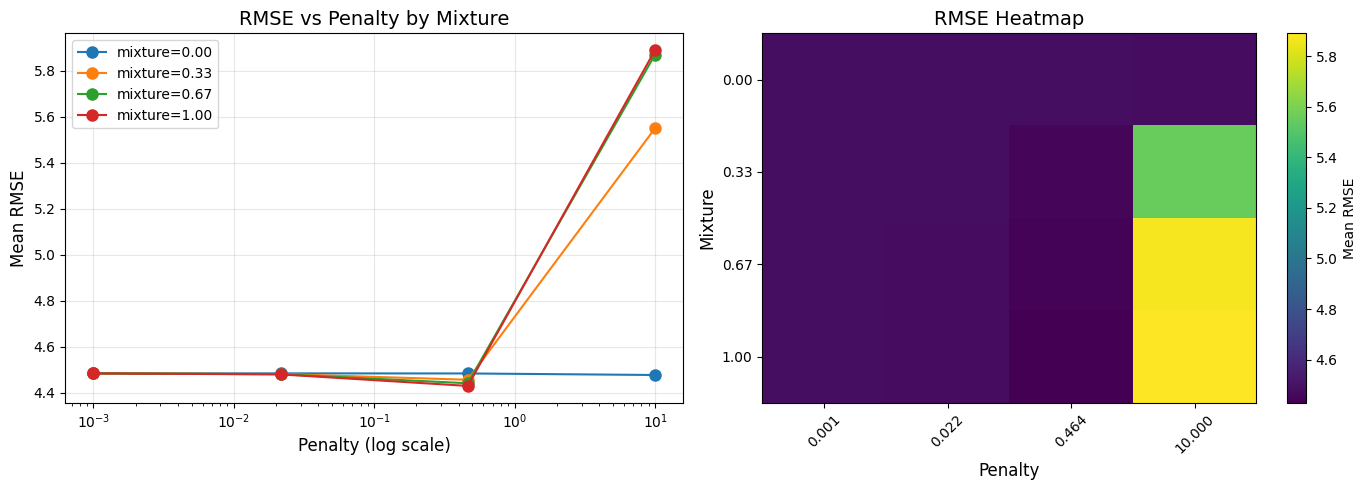


Best performance achieved at:
Penalty: 0.4642
Mixture: 1.00
Mean RMSE: 4.4296


In [10]:
# Calculate mean RMSE for each config
rmse_summary = all_metrics[all_metrics['metric'] == 'rmse'].groupby('.config').agg({
    'value': ['mean', 'std']
}).reset_index()
rmse_summary.columns = ['.config', 'mean_rmse', 'std_rmse']

# Merge with parameter values
rmse_with_params = rmse_summary.merge(param_grid, on='.config')

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE vs penalty for different mixture values
for mixture_val in sorted(rmse_with_params['mixture'].unique()):
    subset = rmse_with_params[rmse_with_params['mixture'] == mixture_val]
    axes[0].plot(subset['penalty'], subset['mean_rmse'], 'o-', 
                 label=f'mixture={mixture_val:.2f}', markersize=8)

axes[0].set_xscale('log')
axes[0].set_xlabel('Penalty (log scale)', fontsize=12)
axes[0].set_ylabel('Mean RMSE', fontsize=12)
axes[0].set_title('RMSE vs Penalty by Mixture', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Heatmap of RMSE
pivot_data = rmse_with_params.pivot(index='mixture', columns='penalty', values='mean_rmse')
im = axes[1].imshow(pivot_data, cmap='viridis', aspect='auto')
axes[1].set_xticks(range(len(pivot_data.columns)))
axes[1].set_xticklabels([f'{x:.3f}' for x in pivot_data.columns], rotation=45)
axes[1].set_yticks(range(len(pivot_data.index)))
axes[1].set_yticklabels([f'{y:.2f}' for y in pivot_data.index])
axes[1].set_xlabel('Penalty', fontsize=12)
axes[1].set_ylabel('Mixture', fontsize=12)
axes[1].set_title('RMSE Heatmap', fontsize=14)
plt.colorbar(im, ax=axes[1], label='Mean RMSE')

plt.tight_layout()
plt.show()

print("\nBest performance achieved at:")
best_row = rmse_with_params.loc[rmse_with_params['mean_rmse'].idxmin()]
print(f"Penalty: {best_row['penalty']:.4f}")
print(f"Mixture: {best_row['mixture']:.2f}")
print(f"Mean RMSE: {best_row['mean_rmse']:.4f}")

## 10. Finalize and Fit Best Model

Create final workflow with optimized parameters.

In [11]:
# Finalize workflow with best parameters
final_wf = finalize_workflow(wf, best_params)

# Fit on full training data
final_fit = final_wf.fit(train_data)

# Predict on test data
test_predictions = final_fit.predict(test_data)

print("Final model trained with best parameters!")
print(f"\nBest parameters: {best_params}")

Final model trained with best parameters!

Best parameters: {'penalty': 0.46415888336127775, 'mixture': 1.0}


## 11. Evaluate Final Model

Assess performance on held-out test set.

Test set performance:

      metric     value
0       rmse  4.346333
1        mae  3.835459
2  r_squared  0.403670


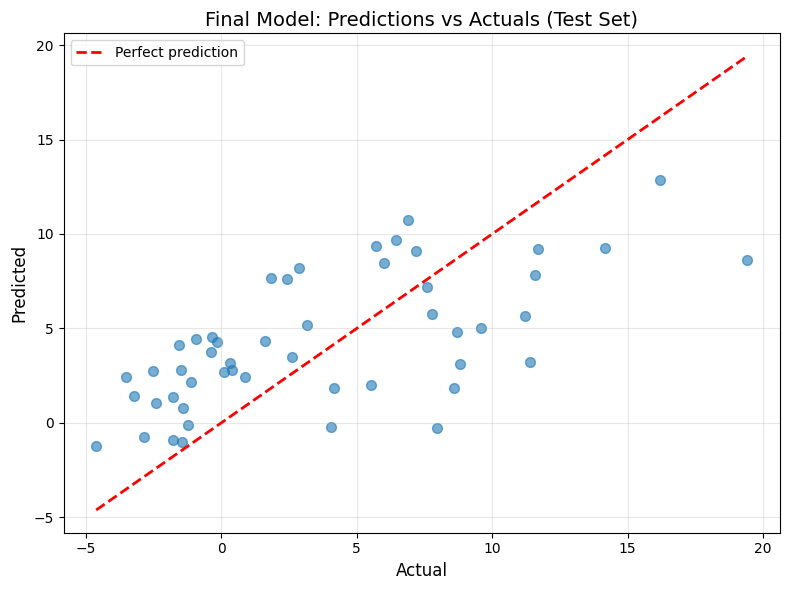

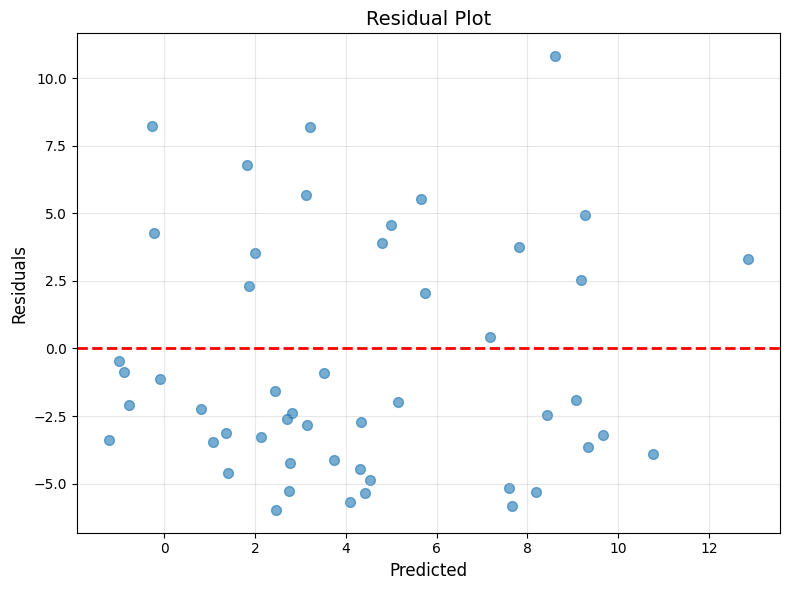

In [12]:
# Calculate test metrics
test_metrics = metrics(test_data['y'], test_predictions['.pred'])

print("Test set performance:\n")
print(test_metrics)

# Plot predictions vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(test_data['y'], test_predictions['.pred'], alpha=0.6, s=50)
plt.plot([test_data['y'].min(), test_data['y'].max()],
         [test_data['y'].min(), test_data['y'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.title('Final Model: Predictions vs Actuals (Test Set)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate residuals
residuals = test_data['y'].values - test_predictions['.pred'].values

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(test_predictions['.pred'], residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Random Grid Search

Demonstrate random parameter sampling for larger search spaces.

In [13]:
# Create random grid
random_grid = grid_random(param_info, size=20, seed=42)

print(f"Random grid with {len(random_grid)} combinations:\n")
print(random_grid.head(10))

# Run random grid search (smaller sample for demo)
print("\nRunning random grid search...")
random_results = tune_grid(
    wf,
    folds,
    grid=random_grid,
    metrics=metrics
)

# Compare best result
random_best = random_results.select_best('rmse', maximize=False)
print("\nBest from random search:")
print(random_best)

Random grid with 20 combinations:

    penalty   mixture     .config
0  0.031489  0.611853  config_001
1  6.351221  0.139494  config_002
2  0.847180  0.292145  config_003
3  0.248104  0.366362  config_004
4  0.004208  0.456070  config_005
5  0.004207  0.785176  config_006
6  0.001707  0.199674  config_007
7  2.915443  0.514234  config_008
8  0.253782  0.592415  config_009
9  0.679658  0.046450  config_010

Running random grid search...

Best from random search:
{'penalty': 0.25378155082656645, 'mixture': 0.5924145688620425}


## 13. Baseline: fit_resamples()

Evaluate a fixed model without tuning for comparison.

In [14]:
# Create a baseline workflow with fixed parameters
baseline_spec = linear_reg(penalty=0.1, mixture=0.5)
baseline_wf = workflow().add_formula("y ~ x1 + x2 + x3 + x4 + x5").add_model(baseline_spec)

# Evaluate without tuning
print("Evaluating baseline model...")
baseline_results = fit_resamples(
    baseline_wf,
    folds,
    metrics=metrics
)

# Collect metrics
baseline_metrics = baseline_results.collect_metrics()

print("\nBaseline model performance (penalty=0.1, mixture=0.5):\n")
print(baseline_metrics.groupby('metric')['value'].agg(['mean', 'std']))

# Compare with tuned model
tuned_rmse = tune_results.show_best('rmse', n=1, maximize=False)['mean'].iloc[0]
baseline_rmse = baseline_metrics[baseline_metrics['metric'] == 'rmse']['value'].mean()

improvement = (baseline_rmse - tuned_rmse) / baseline_rmse * 100
print(f"\nTuning improved RMSE by {improvement:.2f}%")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Tuned RMSE: {tuned_rmse:.4f}")

Evaluating baseline model...

Baseline model performance (penalty=0.1, mixture=0.5):

               mean       std
metric                       
mae        3.725239  0.341980
r_squared  0.348101  0.340926
rmse       4.470417  0.417840

Tuning improved RMSE by 0.91%
Baseline RMSE: 4.4704
Tuned RMSE: 4.4296


## Summary

This demo covered:

1. **Marking parameters for tuning** with `tune()`
2. **Grid generation** with `grid_regular()` and `grid_random()`
3. **Grid search** with `tune_grid()` and cross-validation
4. **Result analysis** with `TuneResults` methods:
   - `collect_metrics()` - Get all metrics
   - `show_best()` - Show top configurations
   - `select_best()` - Select absolute best
   - `select_by_one_std_err()` - Select simpler model
5. **Model finalization** with `finalize_workflow()`
6. **Baseline evaluation** with `fit_resamples()`

## Key Takeaways:

- Hyperparameter tuning can significantly improve model performance
- Cross-validation provides robust estimates of generalization
- The one-standard-error rule helps avoid overfitting
- Random grids are efficient for exploring large parameter spaces
- Always compare tuned models against simple baselines